<a href="https://colab.research.google.com/github/FacuBelisario/Tesis-MSE/blob/master/single_axis_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Control de un solo eje

A continuación se presenta un diseño completo de un sistema de control de un solo eje incluyendo un filtro de Kalman para determinación de actitud obtenido del libro **ADCS: Spacecraft Attitude Determination and Control** (Michael Paluszek, Elseiver 2023).

El controlador es configurado como un regulador, por lo que mantiene el ángulo pero no tiene un set point de entrada. El sistema completo se muestra en la siguiente Figura.

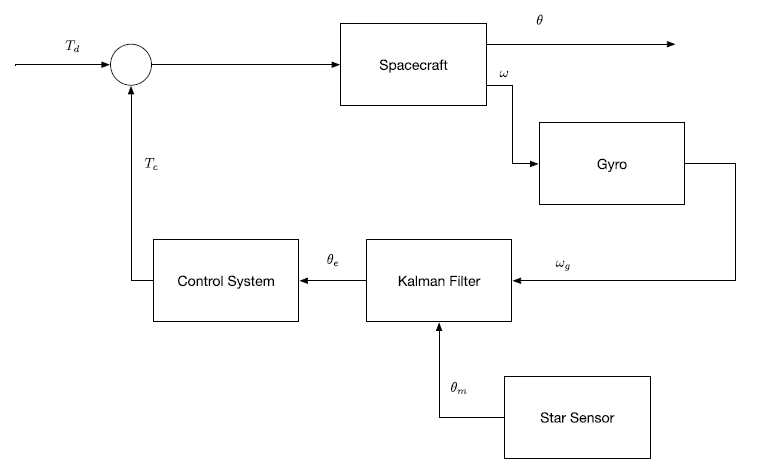

Los dos sistemas dinámicos que necesitan ser modelados en este ejemplo son el satélite y el gyro.

El modelo del satélite es un integrador doble:

$I \ddot{\theta} = T_{c} + T_{d} $

ó

$\dot{\theta} = \omega$

$I \dot{\omega} = T_{c} + T_{d}$

donde $\theta$ es el ángulo real y $\omega$ es la velocidad angular real, $I$ es la inercia, $T_{c}$ es el torque de control y $T_{d}$ es el torque pertubador.

Por otro lado, el modelo del gyro es un integrador simple:

$\dot{\theta}_{g} = \omega + b + v_{\theta}$

$\dot{b} = v_{b}$

donde $\theta_{g}$ es la integral de la velocidad angular verdadera  $\omega$ más el bias $b$. El bias se obtiene del ruido blanco, es decir que es un proceso random-walk. $v_{b}$ el la entrada de ruido del bias y $v_{\theta}$ es el ruido blanco del ángulo.


# Ejemplo: Single-axis step response

In [1]:
import numpy as np
import matplotlib.pyplot as plt